In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

Dataset: GSE118487, A single-cell RNA-seq analysis of molecular characterization of hypothalamic progenitor

cells Object: Homo sapiens

Sample: GSM3330882 GW10-Hy, human embryonic hypothalamic tissues

Processing steps: dissection, papain-based tissue dissociation into single-cell suspension, partitioning into Gel
Bead-In-EMulsions (GEMs) by 10x GemCode™, cDNA libraries preparation with Single Cell 3’ Reagent
Kits, sequencing.

Platform: Illumina HiSeq 4000 (Homo sapiens)

#### First, we loaded the 10x data into an AnnData object

Initially, we have 7148 cells and 32738 genes present.

In [2]:
adata = sc.read_10x_mtx(
    '/home/alevtina/Downloads/gse/1',
    var_names='gene_symbols',
    cache=True)    
adata

AnnData object with n_obs × n_vars = 7148 × 32738
    var: 'gene_ids'

#### Then, performed basic filtering (filtered out genes which were found in less than 10 cells, as well as cells which expressed less than 20 genes)

This left us with 7148 cells and 15105 genes

In [3]:
sc.pp.filter_cells(adata, min_genes=20)
sc.pp.filter_genes(adata, min_cells=20)

In [4]:
adata

AnnData object with n_obs × n_vars = 7148 × 15105
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

#### After that, attempted to find dying cells with high percentage of mitochondrial genes expression:

In [5]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=True, inplace=True)

In [6]:
adata.var['mt'].value_counts()

False    15092
True        13
Name: mt, dtype: int64

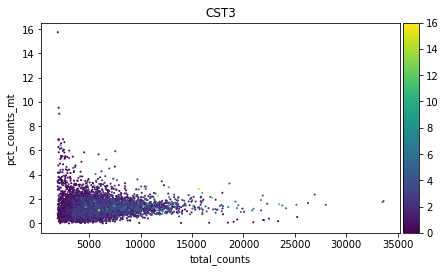

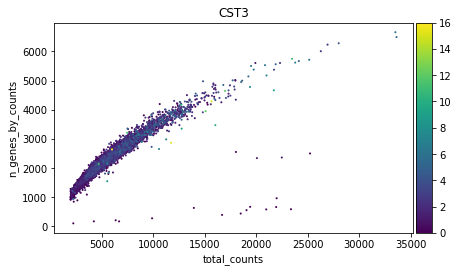

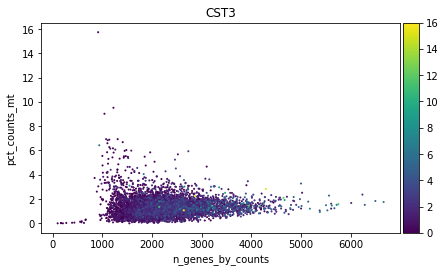

In [7]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color='CST3')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='CST3')
sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_mt', color='CST3')

As we can see, most cells were very much alive. Still, we filtered out some dying ones as well as cells with
very low coverage. 7148-7107=41 cells were filtered out.

In [8]:
adata = adata[adata.obs.n_genes_by_counts > 1000, :].copy()
adata = adata[adata.obs.pct_counts_mt < 6, :].copy()

adata

AnnData object with n_obs × n_vars = 7107 × 15105
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

This was the resulting jointplot:

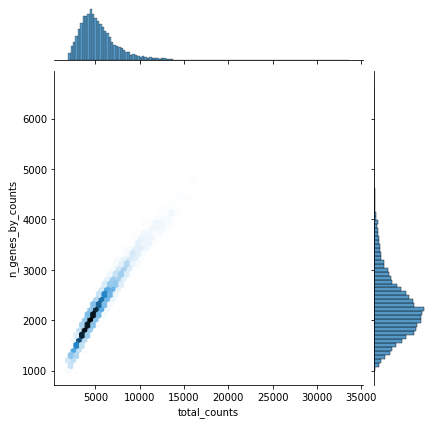

In [11]:
import scanpy as sc
import seaborn as sns

sns.jointplot(
    data=adata.obs,
    x="total_counts",
    y="n_genes_by_counts",
    kind="hex"
)

#### Then, we normalized and filtered out the data, comparing the distribution of the top-20 highest expressed genes:

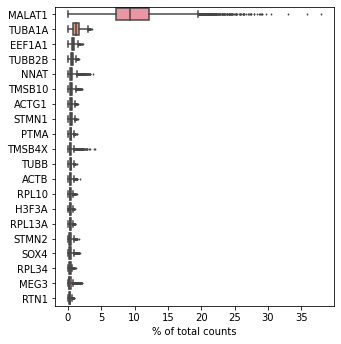

In [12]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [13]:
sc.pp.normalize_total(adata, target_sum=1e4) # Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, so that counts become comparable among cells.
sc.pp.log1p(adata) # log-normalization

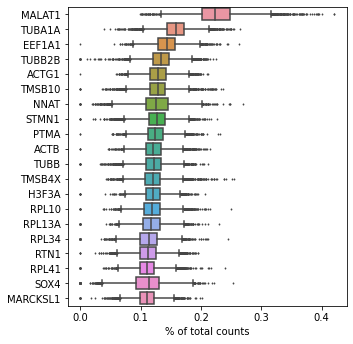

In [14]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Indeed, gene counts look normalized now.

#### Then, we searched for biologically variable genes:

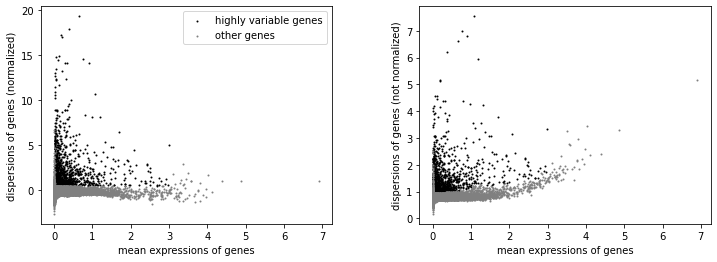

In [21]:
import matplotlib.pyplot as plt
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
gca = sc.pl.highly_variable_genes(adata, show=False, log=False)

In [22]:
adata.var['highly_variable'].value_counts()

False    13829
True      1276
Name: highly_variable, dtype: int64

#### And proceeded with PCA dimensionality reduction

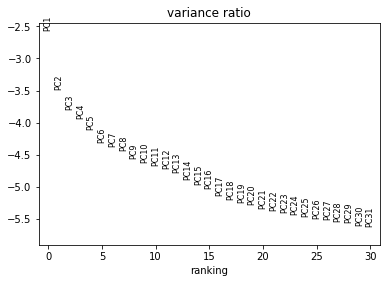

In [23]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

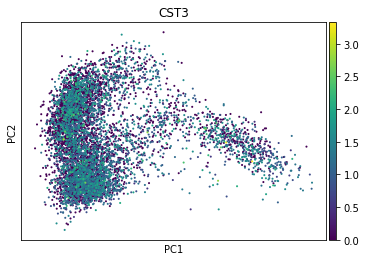

In [24]:
sc.pl.pca(adata, color='CST3')

2022-04-27 18:58:50.498788: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/google/chrome:/opt/google/chrome/lib
2022-04-27 18:58:50.498813: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


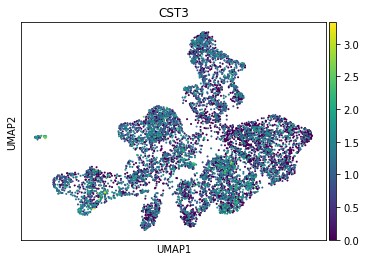

In [25]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=20)
sc.tl.umap(adata)
sc.pl.umap(adata, color='CST3')

#### Performed clustering:

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


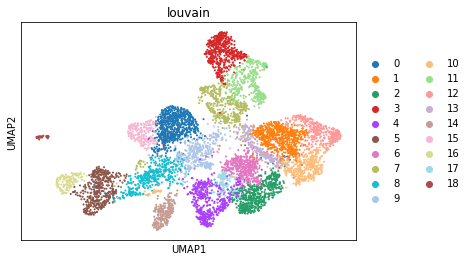

In [26]:
%pip install igraph
import igraph
%pip install louvain
import louvain

sc.tl.louvain(adata, resolution=1.2)
sc.pl.umap(adata, color='louvain')

A total of 19 clusters were found. This is consistent the previous analysis performed with R. and perfectly corresponds with the article: its authors identified ‘HPCs, nine genetic clusters of glutamatergic neurons and nine genetic clusters of GABAergic neurons’. *HPCs are hematopoietic progenitor cells

#### We also relied on the article to annotate functional clusters using specific markers:

The progenitors - classic genes, such as VIM, NES and ASCL1

The neuronal clusters - neuronal markers SYT1 and SNAP25

Glutamatergic neurons - SLC17A6

GABAergic neurons - SLC32A1

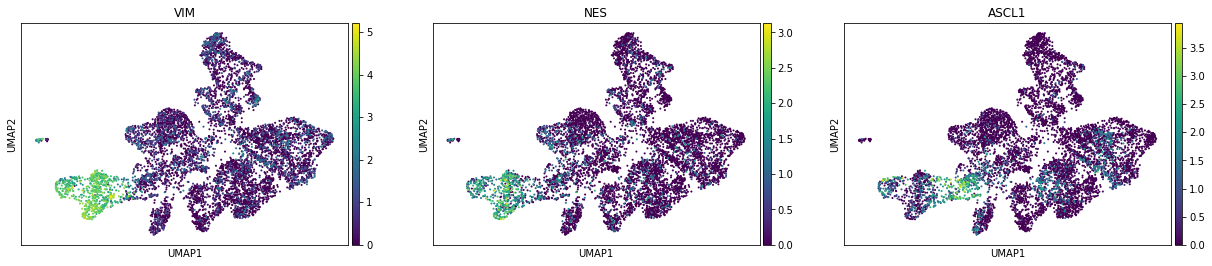

In [27]:
sc.pl.umap(adata, color=["VIM", "NES", "ASCL1"])

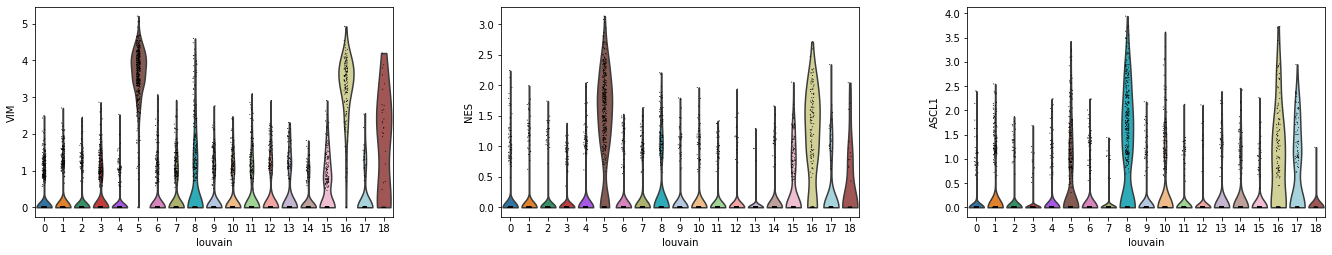

In [28]:
sc.pl.violin(adata, ["VIM", "NES", "ASCL1"], groupby='louvain')

As we can see, clusters 5, 8, 16, 17 and 18 probably correspond to progenitor cells.

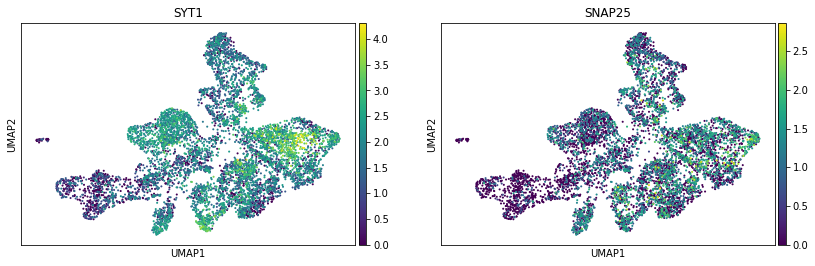

In [29]:
sc.pl.umap(adata, color=["SYT1", "SNAP25"])

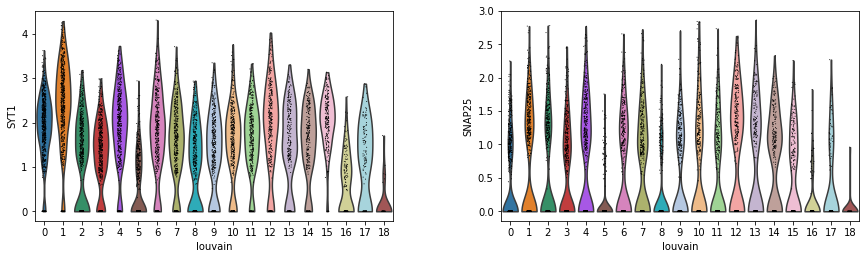

In [30]:
sc.pl.violin(adata, ["SYT1", "SNAP25"], groupby='louvain')

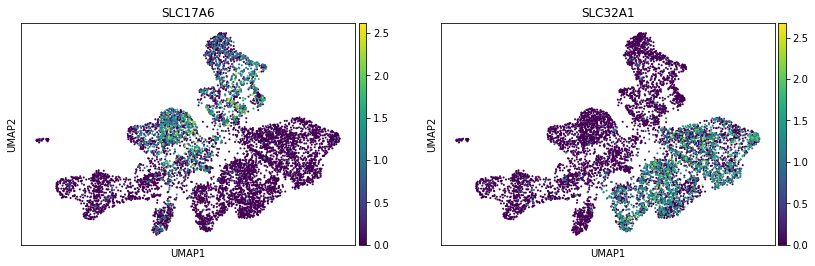

In [31]:
sc.pl.umap(adata, color=["SLC17A6", "SLC32A1"])

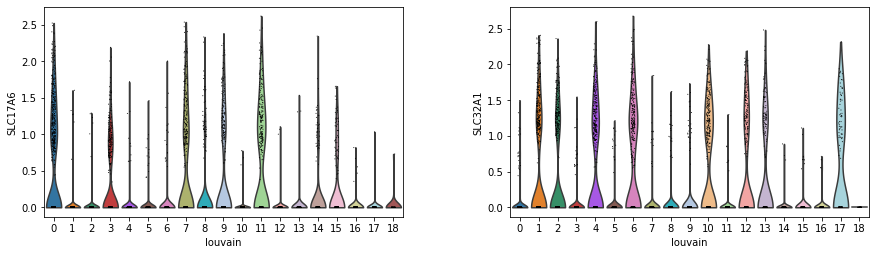

In [32]:
sc.pl.violin(adata, ["SLC17A6", "SLC32A1"], groupby='louvain')

Clusters 0, 3, 7, 9, 11, 14, 15 are primarily glutamatergic neurons. 1, 2, 4, 6, 10, 12, 13 and 17 - GABAergic.

Also, like in case of analysis with R, ASCL1 expression is different from expression of VIM and NES. Unlike the analysis with R, the separation between neuronal and progenitor cells is less obvious. (need a pic to compare)

#### Ran differential expression and used Wilcoxon test to identify other cluster markers and referred to the article to compare the results and identify potential spacial clustering

In [33]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,FEZF1,DLX5,MEG3,OTP,ISL1,VIM,DLX1,NRN1,HES6,PEG10,DLX6-AS1,NRN1,MEIS2,GAD1,LHX9,GAP43,TOP2A,DLX2,B2M


Indeed, some of these were identified as region-specific in the paper:\
FEZF2 - PVN/SON\
OTP - PVN/SON, ARC, SMN/MMN\
ISL1 - VMH, ARC\
DLX1 - SCN, PMN, Prethalamus\
DLX6 - SCN, PMN, Prethalamus\
MEIS2 - LH, Prethalamus, LE\
LHX9 - LH

(PVN/SON: paraventricular nucleus/supraoptic nucleus, SCN: suprachiasmatic nucleus, DMH: dorsomedial
hypothalamus, VMH: ventromedial hypothalamus, ARC: arcuate nucleus, LH: lateral hypothalamus, PMN:
premammillary nucleus, MMN: medial mammillary nucleus, SMN: supramammillary nucleus)

Overall, the results somewhat correspond with the results of the article, but help of embryologists and
neurobiologists is needed to make more sense of the obtained data.